# **PREDICCIÓN DE RESULTADOS EN PARTIDOS DE FÚTBOL (PARL-AI)**

---

> Juan Pablo Pérez Leal

> Laura Natalia Jaimes Antolínez






In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ProyectoAI1')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ProyectoAI1


*Importamos las librerias necesarias para el desarrollo de este proyecto.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_theme()
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

*Importamos los respectivos datasets.*

In [ ]:
partidos = pd.read_csv("data/results.csv")
puntajes = pd.read_csv("data/shootouts.csv")

In [ ]:
partidos.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [ ]:
puntajes.head()

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
3,1972-05-19,Thailand,Cambodia,Thailand
4,1973-07-26,Malaysia,Kuwait,Malaysia


A diferencia del anterior dataset, este último tiene los mismos datos pero con menos atributos.

# **PROCESAMIENTO DE DATOS**

1. Se le atribuye a cada país una etiqueta para facilitar su evaluación en los modelos de inferencia y clasificación.

In [ ]:
labels = pd.DataFrame()
nombres = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Paraguay','Peru','Uruguay','Venezuela']
etiquetas = [1,2,3,4,5,6,7,8,9,10]

labels['Pais'] = nombres
labels['ID'] = etiquetas
labels

,Pais,ID
0,Argentina,1
1,Bolivia,2
2,Brazil,3
3,Chile,4
4,Colombia,5
5,Ecuador,6
6,Paraguay,7
7,Peru,8
8,Uruguay,9
9,Venezuela,10


2. Se extraen todos los partidos de equipos Latinoamericanos que se disputaron desde el 2010 hasta la fecha previa de cada torneo.

In [ ]:
################# FILTRAR POR FECHAS #################################
df = partidos
grupos = partidos
df['date'] = pd.to_datetime(df['date'])
start_date = '2010-01-01'
end_date = '2021-06-10'
mask = (df['date'] > start_date) & (df['date'] <= end_date)
df = df.loc[mask]

def preparar_dataset(df):
  
  ################ FILTRAR POR EQUIPOS ####################################
  equipos = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Paraguay','Peru','Uruguay','Venezuela']
  df = df[df['home_team'].isin(equipos) & df['away_team'].isin(equipos) ]


  ################ CODIFICAR CADA UNO DE LOS EQUIPOS ######################
  df = df.replace(['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Paraguay','Peru','Uruguay','Venezuela','Spain','England','Saudi Arabia','United States','Australia','China PR','Canada','India','Netherlands','Qatar','South Africa','Israel'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
  df = df.replace([False,True],[0,1])

  #df.home_team.replace(to_replace=dict(Argentina=1,Bolivia=2), inplace=True)
  ################ CREAMOS UNA COLUMNA CON EL GANADOR DEL PARTIDO ###############  
  condiciones = [df ['home_score']> df ['away_score'],
                df ['home_score'] <df ['away_score']]  
  opciones = ['1', '2']  
  df ['result'] = np.select(condiciones, opciones, default= '0')
  return df

df = preparar_dataset(df)
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
32058,2010-03-31,4,10,0,0,Friendly,Temuco,4,0,0
32239,2010-06-28,3,4,3,0,FIFA World Cup,Johannesburg,21,1,1
32267,2010-08-11,2,5,1,1,Friendly,La Paz,2,0,0
32348,2010-09-03,10,5,0,2,Friendly,Puerto la Cruz,10,0,2
32414,2010-09-07,10,6,1,0,Friendly,Barquisimeto,10,0,1


3. Extraemos cada partido que se jugó en la Copa américa para comprobrar más adelante los resultados de nuestro proyecto.

*Fase de grupos*

In [ ]:
grupos_dataset = partidos
grupos_dataset['date'] = pd.to_datetime(grupos_dataset['date'])
start_date = '2021-06-12'
end_date = '2021-06-30'
mask = (grupos_dataset['date'] > start_date) & (grupos_dataset['date'] <= end_date)
grupos_dataset = grupos_dataset.loc[mask]

grupos_dataset = preparar_dataset(grupos_dataset)
grupos_dataset

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42315,2021-06-13,3,10,3,0,Copa América,Brasilia,3,0,1
42316,2021-06-13,5,6,1,0,Copa América,Cuiaba,3,1,1
42321,2021-06-14,1,4,1,1,Copa América,Rio de Janeiro,3,1,0
42322,2021-06-14,7,2,3,1,Copa América,Goiânia,3,1,1
42350,2021-06-17,5,10,0,0,Copa América,Goiânia,3,1,0
42351,2021-06-17,3,8,4,0,Copa América,Rio de Janeiro,3,0,1
42356,2021-06-18,4,2,1,0,Copa América,Cuiaba,3,1,1
42357,2021-06-18,1,9,1,0,Copa América,Brasilia,3,1,1
42364,2021-06-20,10,6,2,2,Copa América,Rio de Janeiro,3,1,0
42365,2021-06-20,5,8,1,2,Copa América,Goiânia,3,1,2


*Cuartos de finales*

In [ ]:
cuartos_dataset = partidos
cuartos_dataset['date'] = pd.to_datetime(cuartos_dataset['date'])
start_date = '2021-06-30'
end_date = '2021-07-04'
mask = (cuartos_dataset['date'] > start_date) & (cuartos_dataset['date'] <= end_date)
cuartos_dataset = cuartos_dataset.loc[mask]

cuartos_dataset = preparar_dataset(cuartos_dataset)
cuartos_dataset

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42404,2021-07-02,8,7,3,3,Copa América,Goiânia,3,1,0
42405,2021-07-02,3,4,1,0,Copa América,Rio de Janeiro,3,0,1
42412,2021-07-03,9,5,0,0,Copa América,Brasília,3,1,0
42413,2021-07-03,1,6,3,0,Copa América,Goiânia,3,0,1


*Semifinales*

In [ ]:
smf_dataset = partidos
smf_dataset['date'] = pd.to_datetime(smf_dataset['date'])
start_date = '2021-07-04'
end_date = '2021-07-08'
mask = (smf_dataset['date'] > start_date) & (smf_dataset['date'] <= end_date)
smf_dataset = smf_dataset.loc[mask]

smf_dataset = preparar_dataset(smf_dataset)
smf_dataset

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42418,2021-07-05,3,8,1,0,Copa América,Rio de Janeiro,3,0,1
42419,2021-07-06,1,5,1,1,Copa América,Brasília,3,1,0


*Finales*

In [ ]:
f_dataset = partidos
f_dataset['date'] = pd.to_datetime(f_dataset['date'])
start_date = '2021-07-08'
end_date = '2021-07-10'
mask = (f_dataset['date'] > start_date) & (f_dataset['date'] <= end_date)
f_dataset = f_dataset.loc[mask]

f_dataset = preparar_dataset(f_dataset)
f_dataset

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42431,2021-07-09,8,5,2,3,Copa América,Brasília,3,1,2
42434,2021-07-10,3,1,0,1,Copa América,Rio de Janeiro,3,0,2


# ENTRENAMIENTO DE DATOS

Con ayuda del estimador SVR (Support Vector Regressor) y algunos clasificadores como el SVC (Support Vector Classifier) y Random Forest, se espera conocer la precisión de nuestra inferencia dentro de cada encuentro a partir del *Registro Histórico de partidos ganados y perdidos según el país* o el *Número de goles promedio* de cada uno de estos.

**Metodo 1:** Realizar una *Regresión* según el número de goles 

1. Separamos los datos que vamos a utilizar para el entrenamiento y testeo

In [ ]:
datos = df.values[:,:]
n = int(len(datos)*0.8)

X_train = datos[:n,[1,2,7,8]]
X_test = datos[n:,[1,2,7,8]]
y_train = datos[:n,[3,4]]    
y_test = datos[n:,[3,4]]


2. Aplicamos el modelo de regresión SVR (Support Vector Regressor) para conocer su presición de acuerdo a los resultados reales

In [ ]:

def regresion_puntajes(df):
  datos = df.values[:,:]
  n = int(len(datos)*0.8)

  X_train = datos[:n,[1,2,7,8]]
  X_test = datos[n:,[1,2,7,8]]
  y_train = datos[:n,[3,4]]    
  y_test = datos[n:,[3,4]]
  scores = []
  estimators = []
  kernels = ['linear', 'poly', 'rbf']
  for k in kernels:  
    clf = MultiOutputRegressor(SVR(kernel=k),2).fit(X_train, y_train)
    prediction = clf.predict(X_test)
    scores.append(mean_squared_error(y_test,prediction))
    estimators.append(clf)
  #print('MSE = ',scores)
  return estimators

3. Como la regresión devuelve un numero decimal de goles, le hacemos un "post-procesamiento de datos" en donde basado en un cálculo se pondera el puntaje de ese partido

In [ ]:
def puntaje_regresion(prediction):
  ejemplo = np.power(prediction,2) 
  puntaje_local = int((ejemplo[0,0] - 0.5)*1.15)
  puntaje_visitante = int((ejemplo[0,1] - 0.5)*2)
  #print("predict al 2: ", ejemplo)
  print("Local: ", int(puntaje_local), " Puntaje visitante: ", int(puntaje_visitante))  
  if puntaje_local > puntaje_visitante:
    return 1
  elif puntaje_local < puntaje_visitante:
    return 2
  elif puntaje_local == puntaje_visitante:
    return 0

4. Ahora, obteniendo los puntajes realizamos la comparación ente los distintos tipos de kernel usados

In [ ]:
estimators = regresion_puntajes(df)

ejes = []
for i in range(3):
  puntajes = []
  predicciones = estimators[i].predict(X_test)
  for prediccion in predicciones:
    puntajes.append(puntaje_regresion([prediccion]))
  ejes.append(puntajes)
  print("\nKernel # ",i+2)

Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  4  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  3  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  3  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1 

5. Se realiza un análisis con los puntajes con el fin de observar cual es el mejor tipo de kernel

In [ ]:
ejes = np.array(ejes)
ejes = np.transpose(ejes)

metrics = []
#metrics_accuracy = []
for i in range(3):
  metrics.append(mean_squared_error(ejes[:,i],df.values[n:,9]))
  #metrics_accuracy.append(accuracy_score(ejes[:,i], df.values[n:,9]))
#print(metrics_accuracy)
metrics


[0.9420289855072463, 0.927536231884058, 0.8840579710144928]

In [ ]:
comparison = []
for i in range(3):
  comparison.append(abs(ejes[:,i]-df.values[n:,9].astype(int)))
comparison = np.array(comparison)
comparison = np.transpose(comparison)
metrica_acc = []
for i in range(3):
  contador = 0
  for j in range(len(comparison)):
    if comparison[j,i] == 0:
      contador += 1
  metrica_acc.append(contador)
metrica_acc = np.array(metrica_acc)/69
metrica_acc



array([0.4057971 , 0.37681159, 0.42028986])

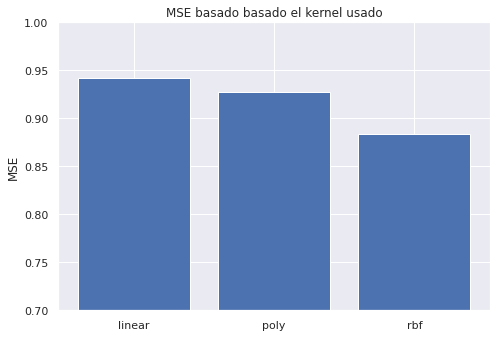

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['linear', 'poly', 'rbf']
kernels = kernels
MSE = metrics
ax.bar(kernels,MSE)
ax.set_ylabel('MSE')
ax.set_title('MSE basado basado el kernel usado')
plt.ylim([0.7, 1])
plt.show()

Debido a la transformación que se tiene que realizar sobre los datos inferidos es posible obtener unos resultados tengan una baja precisión, asi que se aborda el problema de otro modo, hacer regresión esta vez al ganador del partido, sin importar su puntaje


En este caso, aunque todos los kernels usados tienen un desempeño similar, el rbf ofrece un mejor desempeño al resto

**Metodo 2:** Regresión al Registro Histórico de los Ganadores en cada partido disputado

In [ ]:
datos = df.values[:,:]
n = int(len(datos)*0.8)

X_train = datos[:n,[1,2,7,8]]
X_test = datos[n:,[1,2,7,8]]
y_train = datos[:n,9]    
y_test = datos[n:,9]
scores = []
estimators = []
kernels = ['linear', 'poly', 'rbf']
for k in kernels:    
  est = SVR(kernel=k)
  est.fit(X_train, y_train)
  prediction = est.predict(X_test)
  scores.append(mean_squared_error(y_test,prediction))
  estimators.append(est)

print(scores)

prediction = est.predict([[4,1,1,0]])
print(prediction)# Argentina vs Venezuela en Argentina en un partido no neutral


def puntaje_regresion_resultado(prediction):
  if prediction <= 0.85:
    return 0  
  elif prediction >= 1.15:
    return 2
  else:
    return 1

def convertir_prediccion(valor):
  resultados = ['Empate','Gana Local','Gana visitante']
  return resultados[valor]

v = puntaje_regresion_resultado(prediction)
convertir_prediccion(v)

[0.6651685395304188, 0.66376917926059, 0.6680991133994054]
[0.92575675]


'Gana Local'

Evaluamos la precisión del método midiendo su precisión mediante el MSE

In [ ]:
ejes = []
for i in range(3):
  puntajes = []
  predicciones = estimators[i].predict(X_test)
  for prediccion in predicciones:
    puntajes.append(puntaje_regresion_resultado(prediccion))
  ejes.append(puntajes)
ejes = np.array(ejes)
ejes.shape
  

(3, 69)

In [ ]:
ejes = np.array(ejes)
ejes = np.transpose(ejes)

metrics2 = []
#metrics_accuracy = []
for i in range(3):
  metrics2.append(mean_squared_error(ejes[:,i],df.values[n:,9]))
  #metrics_accuracy.append(accuracy_score(ejes[:,i], df.values[n:,9]))
#print(metrics_accuracy)
metrics2


[0.6521739130434783, 0.7246376811594203, 0.782608695652174]

In [ ]:
comparison2 = []
for i in range(3):
  comparison2.append(abs(ejes[:,i]-df.values[n:,9].astype(int)))
comparison2 = np.array(comparison2)
comparison2 = np.transpose(comparison2)
metrica_acc2 = []
for i in range(3):
  contador = 0
  for j in range(len(comparison2)):
    if comparison2[j,i] == 0:
      contador += 1
  metrica_acc2.append(contador)
metrica_acc2 = np.array(metrica_acc2)/69
metrica_acc2



array([0.34782609, 0.36231884, 0.34782609])

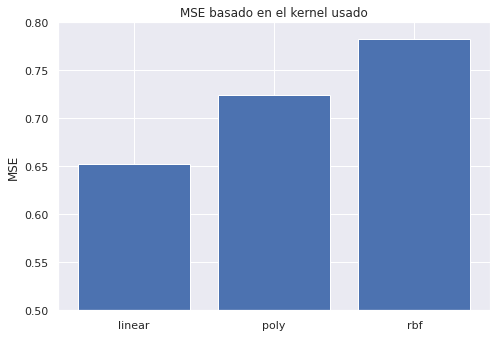

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['linear', 'poly', 'rbf']
kernels = kernels
MSE = metrics2
ax.bar(kernels,MSE)
ax.set_ylabel('MSE')
ax.set_title('MSE basado en el kernel usado')
plt.ylim([0.5, 0.8])
plt.show()

Para este caso se ve que mediante un kernel lineal se obtienen las mejores regresiones. Además se ve que mediante este método se obtiene el mejor valor de mse.

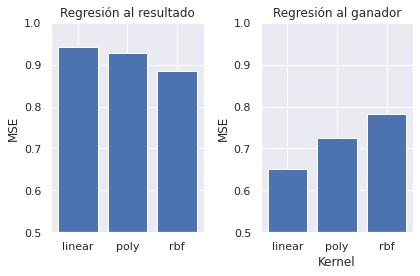

In [ ]:

kernels = ['linear', 'poly', 'rbf']
MSE1 = metrics
MSE2 = metrics2
f, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.bar(kernels,MSE1)
ax2.bar(kernels,MSE2)
ax1.set_ylabel('MSE')
ax2.set_ylabel('MSE')
ax2.set_xlabel('Kernel')
ax2.set_xlabel('Kernel')
ax1.set_title('Regresión al resultado')
ax2.set_title('Regresión al ganador')
ax1.set_ylim([0.5, 1])
ax2.set_ylim([0.5, 1])

plt.tight_layout()
plt.show()

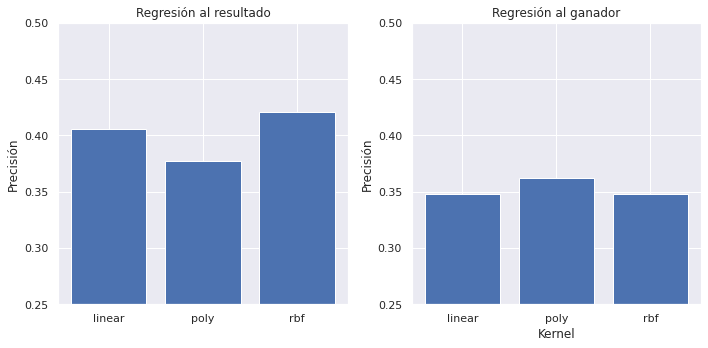

In [ ]:
kernels = ['linear', 'poly', 'rbf']
MSE1 = metrica_acc
MSE2 = metrica_acc2
f, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.bar(kernels,MSE1)
ax2.bar(kernels,MSE2)
ax1.set_ylabel('Precisión')
ax2.set_ylabel('Precisión')
ax2.set_xlabel('Kernel')
ax2.set_xlabel('Kernel')
ax1.set_title('Regresión al resultado')
ax2.set_title('Regresión al ganador')
ax1.set_ylim([0.25, 0.5])
ax2.set_ylim([0.25, 0.5])
f.set_figwidth(10)
f.set_figheight(5)

plt.tight_layout()
plt.show()

# Diseño de Torneos

Una vez realizada la Regresión, diseñamos nuestro propio torneo de la Copa América 2021 según los equipos preestablecidos para jugar cada encuentro

*Fase de grupos*

In [ ]:
grupos = pd.DataFrame()

equipos_grupoA = [1,9,7,4,2]
equipos_grupoB = [3,8,5,6,10]

grupos['Equipo'] = [1,2,3,4,5,6,7,8,9,10]
grupos['Puntos'] = [0,0,0,0,0,0,0,0,0,0]

Utilizamos el modelo con los mejores resultados para realizar las predicciones de los equipos ganadores

Realizamos la fase de grupos

In [ ]:
def fase_de_grupos(grupos):
  datos = grupos.values[:,:]  
  n = int(len(datos)*0.8)
  
  X_validation = datos[:,[1,2,7,8]]
  ground_truth = datos[:,[3,4]]      
  estimadores = regresion_puntajes(df)
  predicciones = estimadores[1].predict(X_validation)         
  return predicciones

Obtenemos los puntajes para cada uno de los partidos en la fase de grupos

In [ ]:
predicciones = fase_de_grupos(grupos_dataset)
puntajes = []
for prediccion in predicciones:
  puntajes.append(puntaje_regresion([prediccion]))

Local:  5  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  3  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  3  Puntaje visitante:  1
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  2  Puntaje visitante:  1
Local:  1  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  2  Puntaje visitante:  1
Local:  1  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0


Ahora, repetimos el proceso para predecir los partidos, pero esta vez se usan los datos de la fase eliminatoria del torneo

In [ ]:
datos = cuartos_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,[3,4]]      
estimadores = regresion_puntajes(df)
#predicciones = estimadores[1].predict(X_validation)     
print(predicciones.shape)
#dar_puntos([predicciones],grupos.values[:,1],grupos.values[:,2])  

predicciones = fase_de_grupos(cuartos_dataset)
puntajes = []
for prediccion in predicciones:
  puntajes.append(puntaje_regresion([prediccion]))
puntajes

(20, 2)
Local:  0  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0
Local:  0  Puntaje visitante:  0
Local:  3  Puntaje visitante:  0


[0, 1, 0, 1]

*Como se registraron empates realizamos penales, con un 50% de probabilidad para cada equipo* 

In [ ]:
from numpy import random

# Porcentaje del 50/50 para este tipo de partidos

x = random.randint(100)
if x > 50:
  print("gana Colombia sisi colombia")  
else:
  print("gana uruguay trsute")
x = random.randint(100)
if x > 50:
  print("gana Peru XD")  
else:
  print("gana Brasil siuu")


gana uruguay trsute
gana Brasil siuu


In [ ]:
x = random.randint(100)
if x > 50:
  print("gana Colombia sisi colombia")  
else:
  print("gana Peru no le saben a los penales")

gana Colombia sisi colombia


*Semifinales:* Se realiza el mismo proceso

In [ ]:
datos = smf_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,[3,4]]      
estimadores = regresion_puntajes(df)

predicciones = fase_de_grupos(smf_dataset)
puntajes = []
for prediccion in predicciones:
  puntajes.append(puntaje_regresion([prediccion]))
puntajes

Local:  3  Puntaje visitante:  0
Local:  1  Puntaje visitante:  0


[1, 1]

Se obtiene como ganador Argentina y Brasil

*Finales*

In [ ]:
datos = f_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,[3,4]]      
estimadores = regresion_puntajes(df)
#predicciones = estimadores[1].predict(X_validation)     
print(predicciones.shape)
#dar_puntos([predicciones],grupos.values[:,1],grupos.values[:,2])  

predicciones = fase_de_grupos(f_dataset)
puntajes = []
for prediccion in predicciones:
  puntajes.append(puntaje_regresion([prediccion]))
puntajes

(2, 2)
Local:  0  Puntaje visitante:  0
Local:  2  Puntaje visitante:  0


[0, 1]

Brasil fue estimado como ganador del torneo y Colombia como ganadora del tercer puesto

##Ahora probemos hacer una estimación usando clasificadores

La intuición basada en hacer regresión a los resultados de cada partido podría verse como clasificar un partido entre victoria, derrota o empate, por este motivo, abordamos el mismo problema usando clasificación.

Usando SVC

In [ ]:
def clasificacion_puntajes(df):
  datos = df.values[:,:]
  n = int(len(datos)*0.8)

  X_train = datos[:n,[1,2,7,8]]
  X_test = datos[n:,[1,2,7,8]]
  y_train = datos[:n,9]    
  y_test = datos[n:,9]
  scores = []
  estimatorsS = []
  kernels = ['linear', 'poly', 'rbf']
  for k in kernels:  
    clf = SVC(kernel=k).fit(X_train, y_train)
    prediction = clf.predict(X_test)
    scores.append(mean_squared_error(y_test,prediction))
    estimatorsS.append(clf)
  #print('MSE = ',scores)
  return estimatorsS

In [ ]:
estimatorss = clasificacion_puntajes(df)
y_test = df.values[n:,9]

ejess = []
for i in range(3):  
  predicciones = estimatorss[i].predict(X_test)
  ejess.append(accuracy_score(predicciones, y_test))  

ejess


[0.34782608695652173, 0.3333333333333333, 0.34782608695652173]

In [ ]:
ejess

[0.34782608695652173, 0.3333333333333333, 0.34782608695652173]

Usando Random Forest

In [ ]:
datos = df.values[:,:]
n = int(len(datos)*0.8)

X_train = datos[:n,[1,2,7,8]]
X_test = datos[n:,[1,2,7,8]]
y_train = datos[:n,9]    
y_test = datos[n:,9]
scores = []
estimatorss = []
rows = []
depth = [20,25,50,100]
trees = [10,50,100,250]
for d in depth:
  estimatorss = []
  for tree in trees:
    estimator = RandomForestClassifier(max_depth=d,criterion='entropy', n_estimators=tree)
    estimator.fit(X_train, y_train)
    estimatorss.append(estimator.score(X_test, y_test))          
  rows.append(estimatorss)
rows


[[0.42028985507246375,
  0.463768115942029,
  0.43478260869565216,
  0.42028985507246375],
 [0.463768115942029,
  0.4492753623188406,
  0.43478260869565216,
  0.4492753623188406],
 [0.5072463768115942,
  0.391304347826087,
  0.42028985507246375,
  0.463768115942029],
 [0.37681159420289856,
  0.4492753623188406,
  0.4492753623188406,
  0.4782608695652174]]

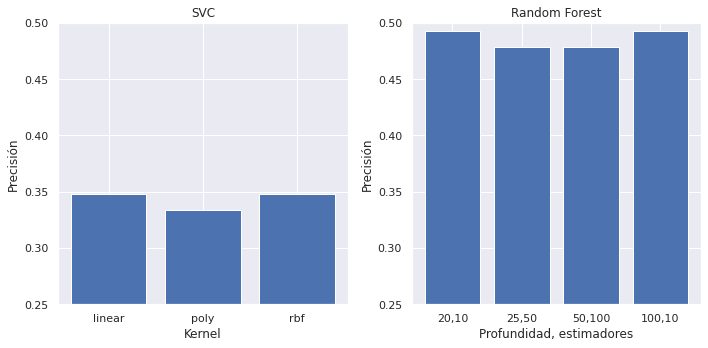

In [ ]:
kernels = ['linear', 'poly', 'rbf']
param = ['20,10', '25,50', '50,100','100,10']
best = np.array([0.4927, 0.4782, 0.4782, 0.4928])
ejess = np.array(ejess)

acc1 = ejess
acc2 = best
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(kernels,acc1)
ax2.bar(param,acc2)
ax1.set_ylabel('Precisión')
ax2.set_ylabel('Precisión')
ax1.set_title('SVC')
ax2.set_title('Random Forest')
ax1.set_ylim([0.25, 0.5])
ax2.set_ylim([0.25, 0.5])
ax2.set_xlabel('Profundidad, estimadores')
ax1.set_xlabel('Kernel')

f.set_figwidth(10)
f.set_figheight(5)

plt.tight_layout()
plt.show()

Se observa que el random forest obtiene muchos mejores resulados que el SVC, que tiene casi el resultado mínimo para este caso de 3 clases que seria 0.33.

## **Validación usando clasificación**

In [ ]:
datos = df.values[:,:]
n = int(len(datos)*0.8)

X_train = datos[:,[1,2,7,8]]
#X_test = datos[n:,[1,2,7,8]]
y_train = datos[:,9]    
#y_test = datos[n:,9]

depth = [20,25,50,100]
trees = [10,50,100,250]
estimator = RandomForestClassifier(max_depth=20,criterion='entropy', n_estimators=10)
estimator.fit(X_train, y_train)

grupos = grupos_dataset.values[:,:]  
X_validation = grupos[:,[1,2,7,8]]
ground_truth = grupos[:,9]      
predicciones = estimator.predict(X_validation)
accuracy = accuracy_score(predicciones, ground_truth)
print("predicciones: \n", predicciones, "\n Precisión: \n", accuracy)
predicciones.shape




predicciones: 
 ['1' '1' '1' '2' '2' '1' '1' '1' '1' '1' '2' '0' '2' '1' '2' '2' '1' '0'
 '1' '0'] 
 Precisión: 
 0.45


(20,)

In [ ]:
datos = cuartos_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,9]      


predicciones = estimator.predict(X_validation)
accuracy = accuracy_score(predicciones, ground_truth)
print("predicciones: \n", predicciones, "\n Precisión: \n", accuracy)
cuartos_dataset



predicciones: 
 ['1' '1' '2' '0'] 
 Precisión: 
 0.25


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42404,2021-07-02,8,7,3,3,Copa América,Goiânia,3,1,0
42405,2021-07-02,3,4,1,0,Copa América,Rio de Janeiro,3,0,1
42412,2021-07-03,9,5,0,0,Copa América,Brasília,3,1,0
42413,2021-07-03,1,6,3,0,Copa América,Goiânia,3,0,1


El estimador predijo que Peru, Uruguay y Argentina pasaron a la final, una precisión del 75%

In [ ]:
datos = smf_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,9]      

predicciones = estimator.predict(X_validation)
accuracy = accuracy_score(predicciones, ground_truth)
print("predicciones: \n", predicciones, "\n Precisión: \n", accuracy)
smf_dataset


predicciones: 
 ['1' '2'] 
 Precisión: 
 0.5


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42418,2021-07-05,3,8,1,0,Copa América,Rio de Janeiro,3,0,1
42419,2021-07-06,1,5,1,1,Copa América,Brasília,3,1,0


El estimador predijo que Brasil y colombia pasaban a la final, un 50% de precisión

In [ ]:
datos = f_dataset.values[:,:]
X_validation = datos[:,[1,2,7,8]]
ground_truth = datos[:,9]      

predicciones = estimator.predict(X_validation)
accuracy = accuracy_score(predicciones, ground_truth)
print("predicciones: \n", predicciones, "\n Precisión: \n", accuracy)
f_dataset

predicciones: 
 ['2' '1'] 
 Precisión: 
 0.5


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
42431,2021-07-09,8,5,2,3,Copa América,Brasília,3,1,2
42434,2021-07-10,3,1,0,1,Copa América,Rio de Janeiro,3,0,2


El estimador predijo a Brasil como el ganador, y a Colombia como el tercer puesto, un 50% de precisión